In [75]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.experimental.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.0.0
Keras Version: 2.2.4-tf

Python 3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]
Pandas 1.3.5
Scikit-Learn 1.0.2
GPU is available
ERROR! Session/line number was not unique in database. History logging moved to new session 520


In [76]:
mirrored_strategy = tf.distribute.MirroredStrategy()
devices = tf.config.experimental.list_physical_devices('GPU')

2022-06-10 02:09:13.242912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
2022-06-10 02:09:13.244114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:03:00.0
2022-06-10 02:09:13.245234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:81:00.0
2022-06-10 02:09:13.246318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:82:00.0
2022-06-10 02:09:13.246428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

In [77]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"])

2022-06-10 02:09:13.638596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
2022-06-10 02:09:13.639531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:03:00.0
2022-06-10 02:09:13.640455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:81:00.0
2022-06-10 02:09:13.641389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:82:00.0
2022-06-10 02:09:13.641441: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

In [78]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import cv2

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

import math

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

In [79]:
labels = pd.read_csv("./datasets/stage_2_train_labels.csv")
labels.head(10)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [80]:
labels.shape

(30227, 6)

In [81]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [82]:
# target 0 --> No pneumonia
labels[labels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [83]:
# target 1 --> Pneumonia
labels[~labels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [84]:
labels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

# Data distribution

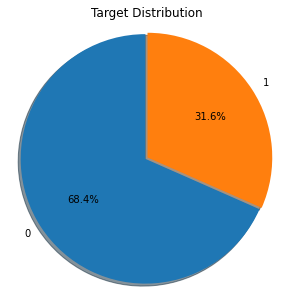

In [85]:
# target distribution
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [86]:
# check unique patients
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [87]:
# check duplicates
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

(3543, 6)

In [88]:
duplicateRowsDF.head(2)

patientId      x      y  width  height  Target
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [89]:
# Duplicate meaning the same patient has two bounding boxes in the same image
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

In [90]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId      x      y  width  height  Target
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [91]:
class_labels = pd.read_csv('./datasets/stage_2_detailed_class_info.csv')
class_labels.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [92]:
class_labels.shape

(30227, 2)

In [93]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [94]:
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

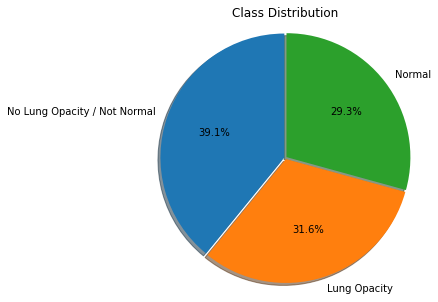

In [95]:
# class distribution
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [96]:
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

(3543, 2)

In [97]:
duplicateClassRowsDF.head(2)

patientId         class
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

In [98]:
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId         class
8  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

In [99]:
# integrate class and labels datasets into the training dataset
training_data = pd.concat([labels, class_labels['class']], axis = 1)
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

Text(0.5, 1.0, 'Class and Target  Distrubution')

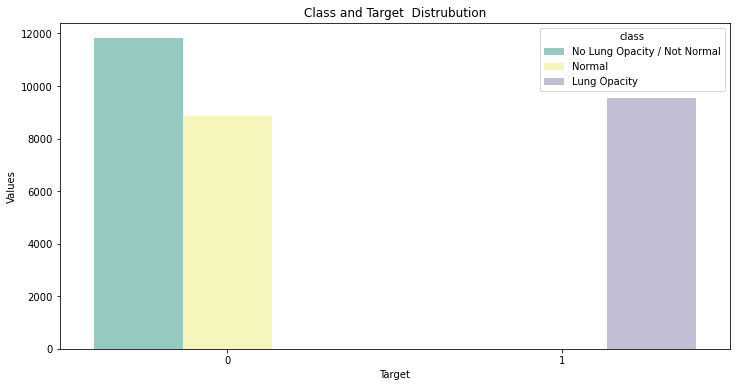

In [100]:
# Target 0 --> Normal or No Lung Opacity / Not Normal class
# Target 1 --> Lung Opacity class

fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

In [101]:
# dicom image analysis
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = './datasets/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

# Data visualization

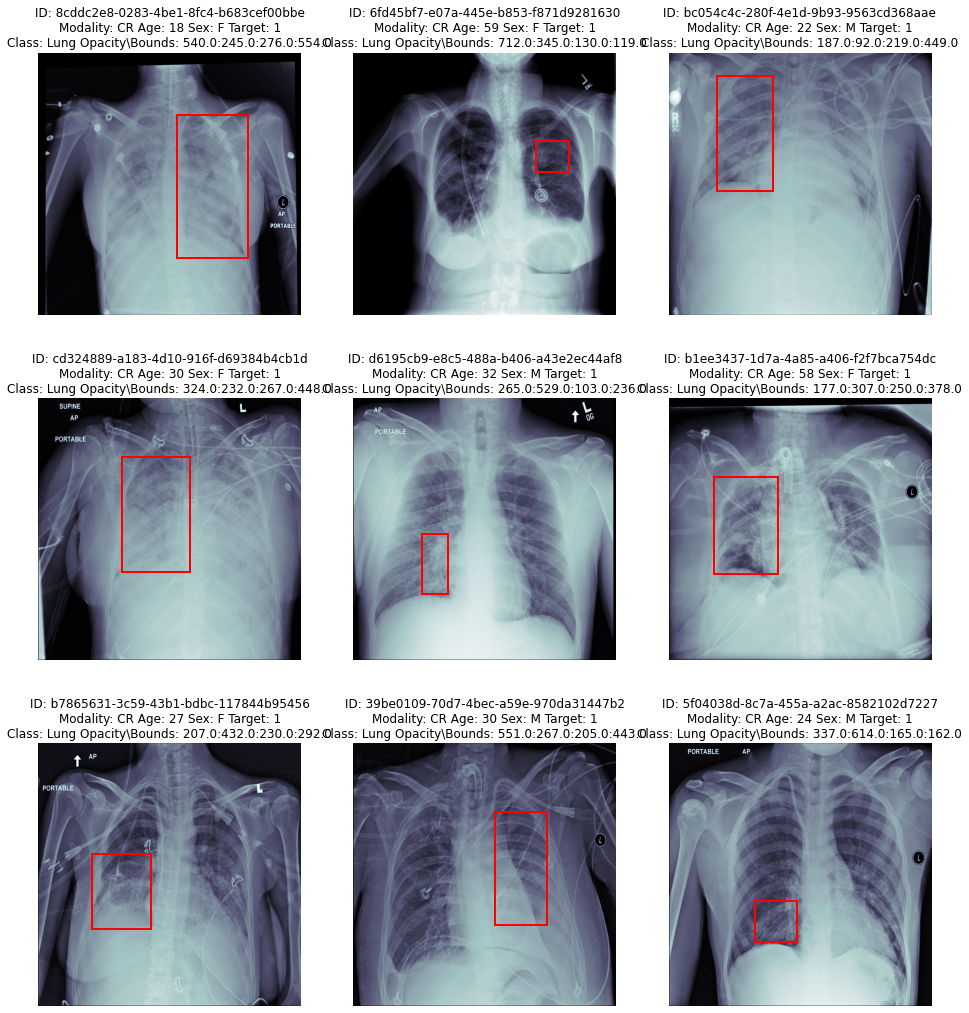

In [102]:
# images corresponding to patients with pneumonia
inspectImages(training_data[training_data['Target']==1].sample(9))

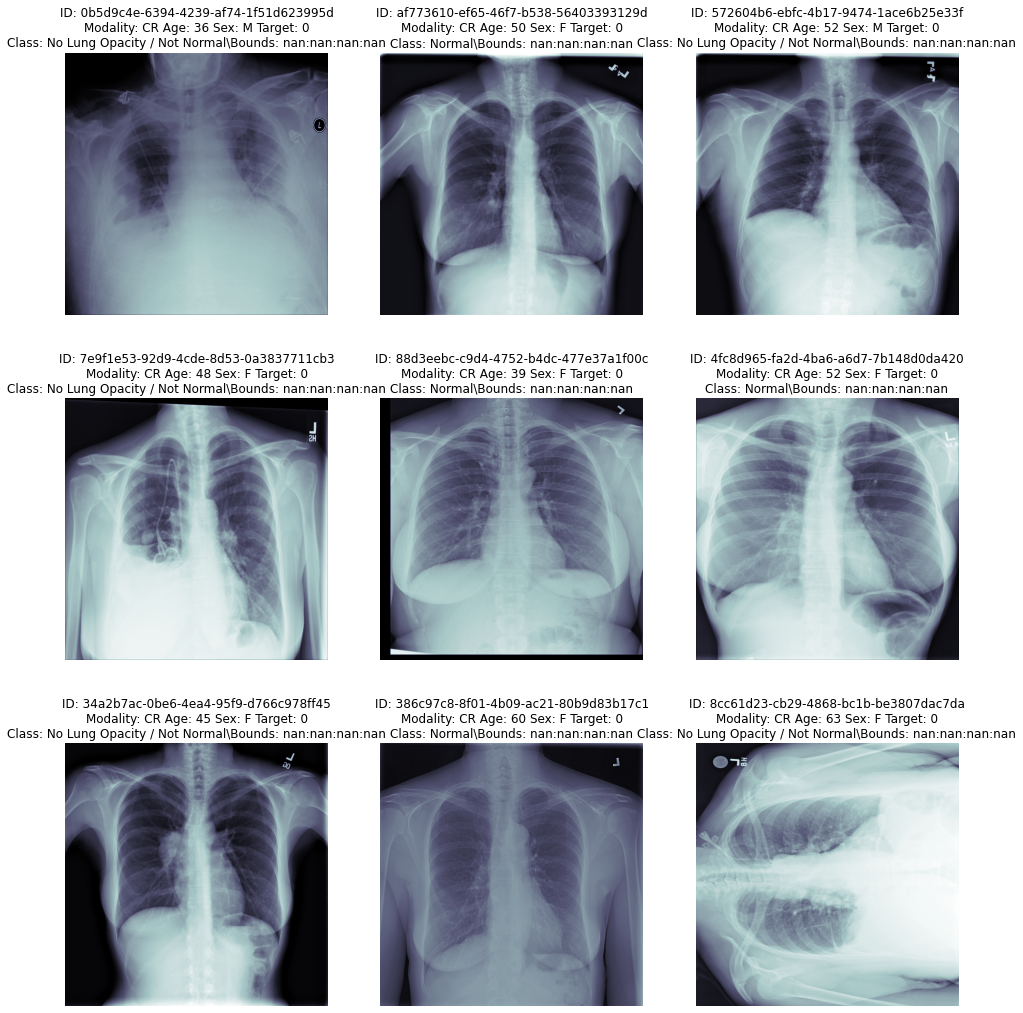

In [103]:
# images corresponding to patients with no pneumonia
inspectImages(training_data[training_data['Target']==0].sample(9))

# Read data

In [104]:
def readDCIMData(rowData):
    dcm_file = './datasets/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [105]:
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))

In [106]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [107]:
training_data['age'] = training_data.age.astype(int)

In [108]:
training_data.describe(include="all").T

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   
sex          30227      2                                     M  17216   
age        30227.0    NaN                                   NaN    NaN   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
sex               NaN         NaN   NaN    NaN    NaN    NaN    NaN  
age         46.797764    16.89294   1.0   34.0   49.0   59.0  155.0

In [109]:
training_data.sex.value_counts()

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

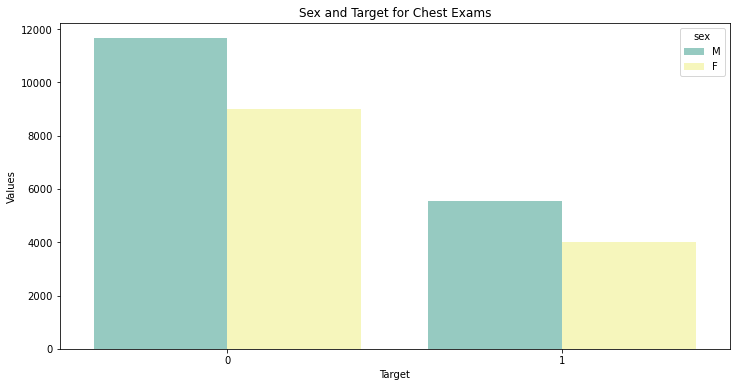

In [110]:
# Distbution of sex wrt target
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

Text(0.5, 1.0, 'Sex and class for Chest Exams')

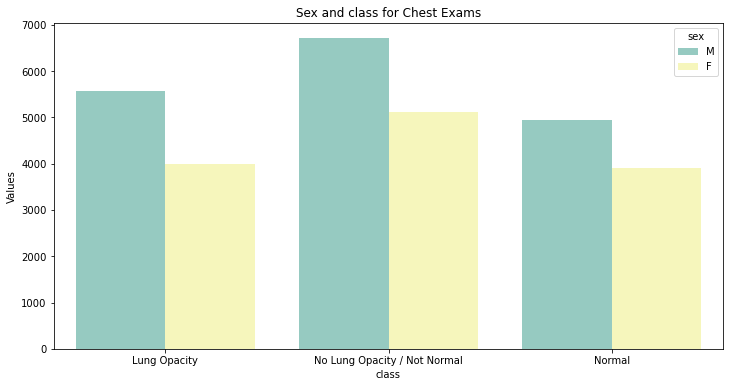

In [111]:
# distbution of sex wrt the class
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

## the number of males in all classes are higher than women

/booleanfs2/sahoo/Data/BooleanLab/Amitash/Softwares/anaconda3/envs/tf-gpu-cuda10/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

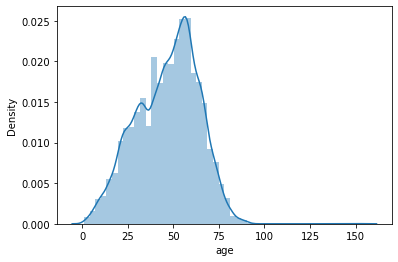

In [112]:
# age distribution
sns.distplot(training_data.age) 

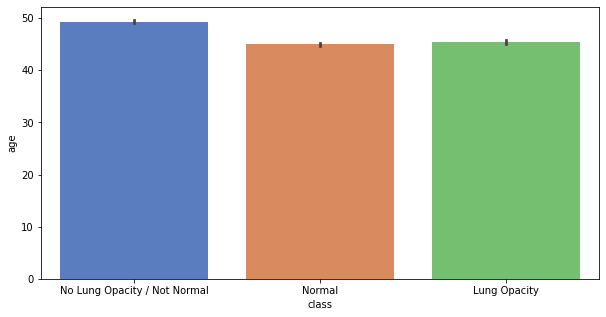

In [113]:
# age distribution wrt class
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=training_data, palette='muted')  # barplot'

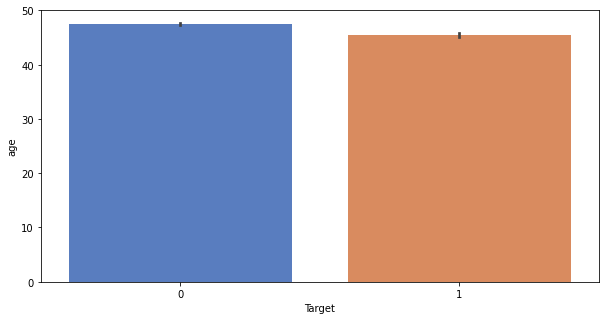

In [114]:
# age distribution wrt target
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=training_data, palette='muted')  # barplot'

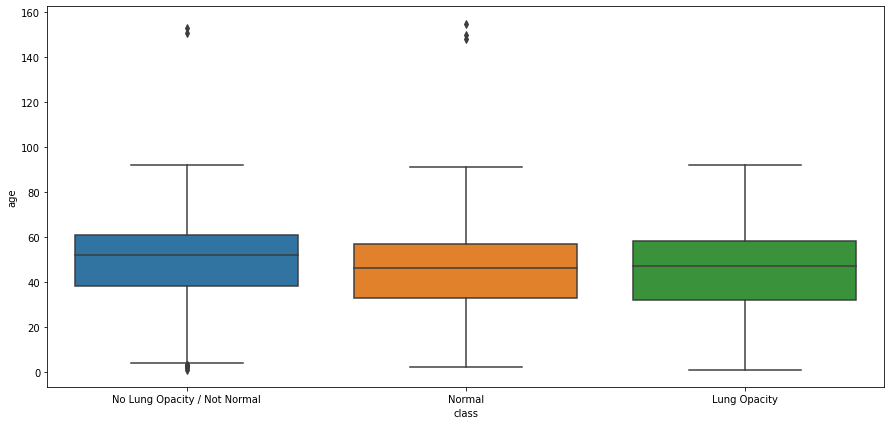

In [115]:
# boxplots
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data)
plt.show()

Distribution of `Age`: Overall and Target = 1


/booleanfs2/sahoo/Data/BooleanLab/Amitash/Softwares/anaconda3/envs/tf-gpu-cuda10/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/booleanfs2/sahoo/Data/BooleanLab/Amitash/Softwares/anaconda3/envs/tf-gpu-cuda10/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


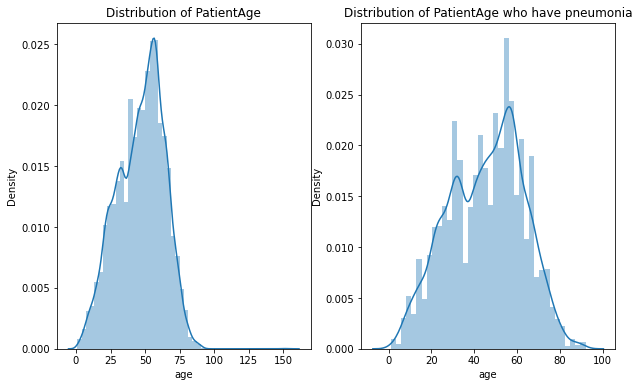

In [116]:
# age distribution for patients with pneumonia
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

<AxesSubplot:>

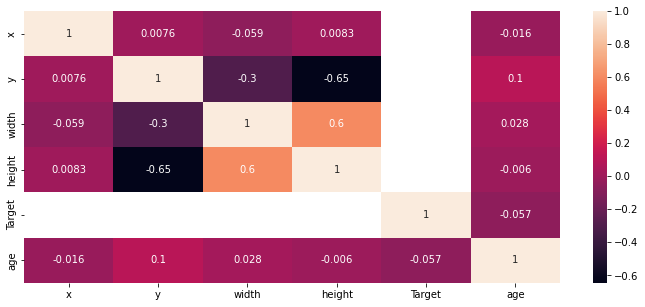

In [117]:
# correlation matrix
corr = training_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

# Preprocessing

In [118]:

from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = './datasets/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        # convert to 3 channels
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
    return tmpImages,tmpLabels

In [119]:
images,labels = populateImage(training_data)

In [122]:
images.shape , labels.shape

((30227, 128, 128, 3), (30227,))

In [150]:
print(labels[:5])

['No Lung Opacity / Not Normal' 'No Lung Opacity / Not Normal'
 'No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


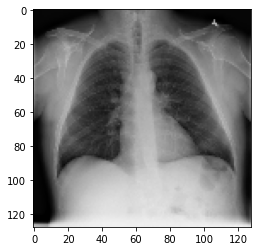

In [123]:
# display random image 
plt.imshow(images[101])

In [124]:
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

# Model Training

In [125]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential

from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

Using TensorFlow backend.


In [126]:
# encode labels into one-hot vectors
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [151]:
print(y)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [1 0 0]
 [1 0 0]]


In [152]:
print(labels)

['No Lung Opacity / Not Normal' 'No Lung Opacity / Not Normal'
 'No Lung Opacity / Not Normal' ... 'Normal' 'Lung Opacity' 'Lung Opacity']


In [127]:
# split into train, test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [129]:
print(X_train.shape)

(21158, 128, 128, 3)
ERROR! Session/line number was not unique in database. History logging moved to new session 525


In [128]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

# Basic CNN (Custom)

In [57]:
# CNN Model

def basic_cnn(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

ERROR! Session/line number was not unique in database. History logging moved to new session 496


In [58]:
# model summary
cnn = basic_cnn(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

In [59]:
# train for 100 epocs with batch size of 64
history_cnn = cnn.fit(X_train, 
                  y_train, 
                  epochs = 100, 
                  validation_data = (X_val,y_val),
                  batch_size = 64)

Train on 21158 samples, validate on 4535 samples
Epoch 1/100
21158/21158 [==============================] - 24s 1ms/step - loss: 1.6561 - accuracy: 0.3860 - val_loss: 1.0770 - val_accuracy: 0.4037
Epoch 2/100
21158/21158 [==============================] - 24s 1ms/step - loss: 1.0619 - accuracy: 0.4077 - val_loss: 1.0597 - val_accuracy: 0.4146
Epoch 3/100
21158/21158 [==============================] - 25s 1ms/step - loss: 1.0369 - accuracy: 0.4296 - val_loss: 1.0338 - val_accuracy: 0.4295
Epoch 4/100
21158/21158 [==============================] - 25s 1ms/step - loss: 1.0153 - accuracy: 0.4573 - val_loss: 1.0188 - val_accuracy: 0.4512
Epoch 5/100
21158/21158 [==============================] - 24s 1ms/step - loss: 1.0042 - accuracy: 0.4656 - val_loss: 1.0146 - val_accuracy: 0.4582
Epoch 6/100
21158/21158 [==============================] - 24s 1ms/step - loss: 0.9937 - accuracy: 0.4775 - val_loss: 1.0114 - val_accuracy: 0.4501
Epoch 7/100
21158/21158 [==============================] - 24s 

In [60]:
from tensorflow.keras.models import load_model
cnn.save('./models/cnn_basic_final.h5')

In [61]:
## evaluate model acuracy on testset
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

4534/4534 [==============================] - 2s 465us/step
Test loss: 0.9262552603678289
Test accuracy: 0.5152183771133423


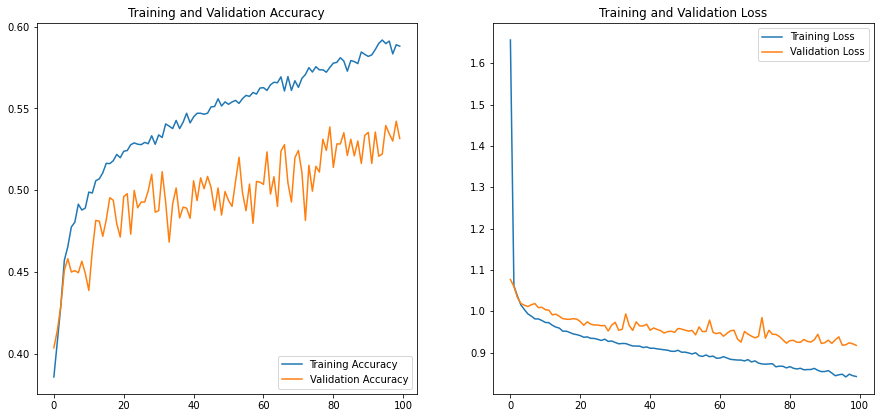

In [62]:
## plot accuracy vs loss graph
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [63]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

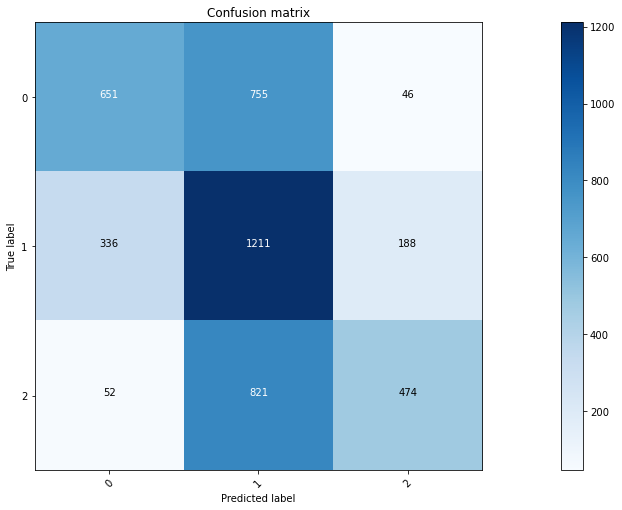

In [64]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# prediction
Y_pred = cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

# Class 0 --> Lung Opacity
# Class 1 --> No Lung Opacity / Not Normal
# Class 2 --> Normal

In [65]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.588052    0.515218     0.434517  0.697983    0.535604       1735

In [77]:
# create a copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()


# VGG16 model

In [79]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train1[0].shape)
base_model.trainable = False ## Not trainable weights

# preprocess input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

In [80]:
# add 2 hidden layers and 1 softmax layer as output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# train the model for 50 epochs and batch size 64
history_vgg16 = cnn_VGG16_model.fit(train_ds, y_train, epochs=50, validation_data=(train_val_df,y_val),  batch_size = 64)

2022-06-09 16:56:40.423761: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 4159832064 exceeds 10% of system memory.


Train on 21158 samples, validate on 4535 samples
Epoch 1/50


21158/21158 [==============================] - 23s 1ms/sample - loss: 0.7036 - accuracy: 0.7224 - val_loss: 0.6948 - val_accuracy: 0.7385
Epoch 2/50
21158/21158 [==============================] - 23s 1ms/sample - loss: 0.6829 - accuracy: 0.7651 - val_loss: 0.6814 - val_accuracy: 0.7671
Epoch 3/50
21158/21158 [==============================] - 23s 1ms/sample - loss: 0.6770 - accuracy: 0.7771 - val_loss: 0.6788 - val_accuracy: 0.7737
Epoch 4/50
21158/21158 [==============================] - 23s 1ms/sample - loss: 0.6724 - accuracy: 0.7864 - val_loss: 0.6831 - val_accuracy: 0.7639
Epoch 5/50
21158/21158 [==============================] - 23s 1ms/sample - loss: 0.6687 - accuracy: 0.7942 - val_loss: 0.6773 - val_accuracy: 0.7752
Epoch 6/50
21158/21158 [==============================] - 23s 1ms/sample - loss: 0.6649 - accuracy: 0.8020 - val_loss: 0.6750 - val_accuracy: 0.7799
Epoch 7/50
21158/21158 [==============================] - 23s 1ms/sample - loss: 0.6609 - accuracy: 0.8111 - val_loss

In [82]:
from tensorflow.keras.models import load_model
cnn_VGG16_model.save('./models/cnn_VGG16_final.h5')

In [89]:
test_ds = preprocess_input(X_test1) 
fcl_loss1, fcl_accuracy1 = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss1)
print('Test accuracy:', fcl_accuracy1)

ERROR! Session/line number was not unique in database. History logging moved to new session 500
4534/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

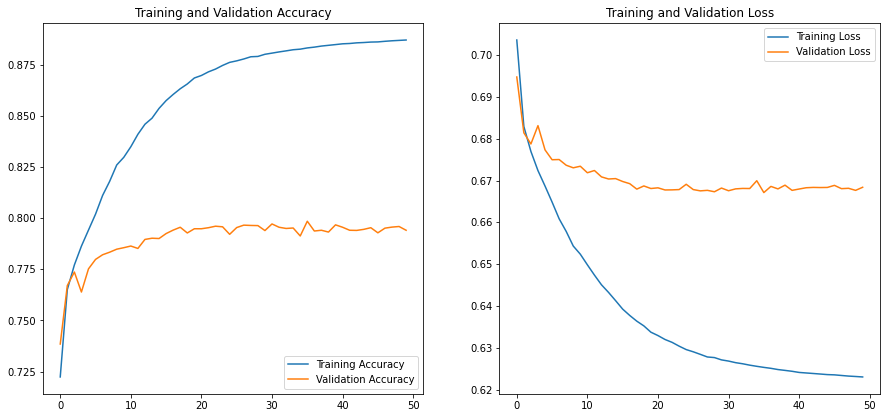

In [90]:
# plot accuracy vs loss graph
acc1 = history_vgg16.history['accuracy']
val_acc1 = history_vgg16.history['val_accuracy']
loss1 = history_vgg16.history['loss']
val_loss1 = history_vgg16.history['val_loss']
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc1, label='Training Accuracy')
plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [91]:
resultDF1 = createResultDf("CNN With VGG16",acc1[-1],fcl_accuracy1)

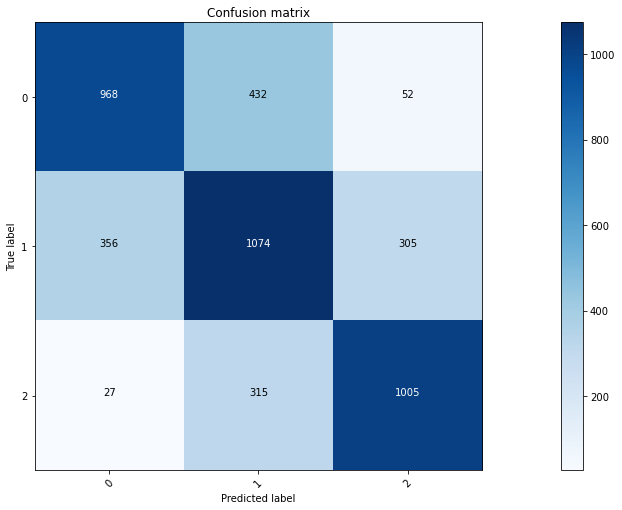

In [92]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# prediction
Y_pred1 = cnn_VGG16_model.predict(test_ds) 
Y_pred_classes1 = np.argmax(Y_pred1,axis = 1) 
Y_true1 = np.argmax(y_test,axis = 1) 
confusion_mtx1 = confusion_matrix(Y_true1, Y_pred_classes1) 
# plot confusion matrix
plot_confusion_matrix(confusion_mtx1, classes = range(3))


In [103]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred1 = np.argmax(y_test,axis = 1) 

Y_testPred1 = cnn_VGG16_model.predict(test_ds)
Y_pred_classes1 = np.argmax(Y_pred1,axis = 1) 

reportData1 = classification_report(Y_truepred1, Y_pred_classes1,output_dict=True)

for data in reportData1:
    if(data == '-1' or data == '1'):
        if(type(reportData1[data]) is dict):
            for subData in reportData1[data]:
                resultDF1[data+"_"+subData] = reportData1[data][subData]

resultDF1

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0  CNN With VGG16  0.887166    0.781356     0.589786   0.61902    0.604049   

   1_support  
0       1735

# CNN with ResNet50 model

In [96]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

# ResNet50

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)

train_ds1 = preprocess_input(X_train1) 
train_val_df1 = preprocess_input(X_val1)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [97]:
cnn_resnet_model.compile(
    optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# train the model for 50 epochs and batch size 64
history_resnet50 = cnn_resnet_model.fit(train_ds1, y_train, epochs=50, validation_data=(train_val_df1,y_val),  batch_size = 64)

2022-06-09 18:00:05.650855: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 4159832064 exceeds 10% of system memory.


Train on 21158 samples, validate on 4535 samples
Epoch 1/50


21158/21158 [==============================] - 52s 2ms/sample - loss: 0.7057 - accuracy: 0.7247 - val_loss: 0.6862 - val_accuracy: 0.7599
Epoch 2/50
21158/21158 [==============================] - 45s 2ms/sample - loss: 0.6648 - accuracy: 0.8034 - val_loss: 0.6735 - val_accuracy: 0.7813
Epoch 3/50
21158/21158 [==============================] - 45s 2ms/sample - loss: 0.6474 - accuracy: 0.8425 - val_loss: 0.6695 - val_accuracy: 0.7935
Epoch 4/50
21158/21158 [==============================] - 45s 2ms/sample - loss: 0.6336 - accuracy: 0.8723 - val_loss: 0.6681 - val_accuracy: 0.7954
Epoch 5/50
21158/21158 [==============================] - 46s 2ms/sample - loss: 0.6220 - accuracy: 0.8958 - val_loss: 0.6659 - val_accuracy: 0.8018
Epoch 6/50
21158/21158 [==============================] - 46s 2ms/sample - loss: 0.6138 - accuracy: 0.9119 - val_loss: 0.6644 - val_accuracy: 0.8040
Epoch 7/50
21158/21158 [==============================] - 46s 2ms/sample - loss: 0.6075 - accuracy: 0.9240 - val_loss

In [98]:
from tensorflow.keras.models import load_model
cnn_resnet_model.save('./models/cnn_resnet_final.h5')

In [99]:
test_ds1 = preprocess_input(X_test1) 
fcl_loss2, fcl_accuracy2 = cnn_resnet_model.evaluate(test_ds1, y_test, verbose=1)
print('Test loss:', fcl_loss2)
print('Test accuracy:', fcl_accuracy2)

4534/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

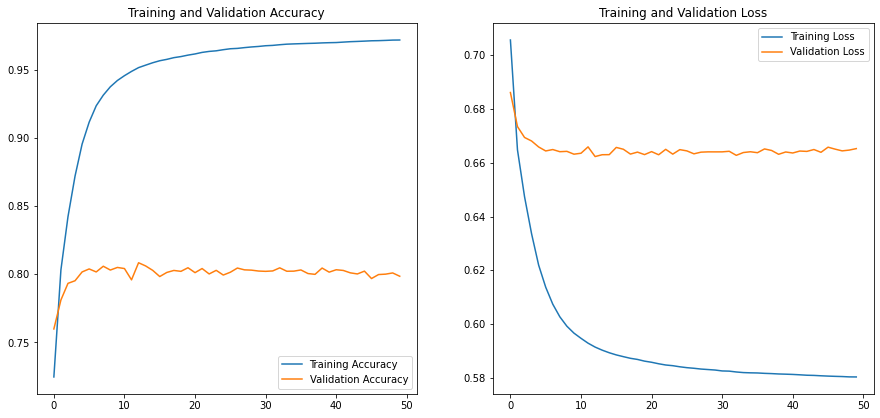

In [100]:
# plot accuracy vs loss graph
acc2 = history_resnet50.history['accuracy']
val_acc2 = history_resnet50.history['val_accuracy']
loss2 = history_resnet50.history['loss']
val_loss2 = history_resnet50.history['val_loss']
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [101]:
resultDF2 = createResultDf("CNN With resnet50",acc2[-1],fcl_accuracy2)

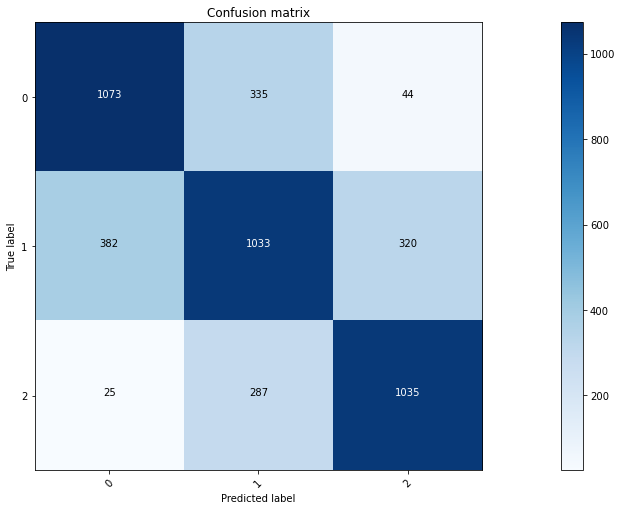

In [102]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# prediction
Y_pred2 = cnn_resnet_model.predict(test_ds1) 
Y_pred_classes2 = np.argmax(Y_pred2,axis = 1) 
Y_true2 = np.argmax(y_test,axis = 1) 
confusion_mtx2 = confusion_matrix(Y_true2, Y_pred_classes2) 
# plot confusion matrix
plot_confusion_matrix(confusion_mtx2, classes = range(3))


In [104]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred2 = np.argmax(y_test,axis = 1) 

Y_testPred2 = cnn_resnet_model.predict(test_ds1)
Y_pred_classes2 = np.argmax(Y_pred2,axis = 1) 

reportData2 = classification_report(Y_truepred2, Y_pred_classes2,output_dict=True)

for data in reportData2:
    if(data == '-1' or data == '1'):
        if(type(reportData2[data]) is dict):
            for subData in reportData2[data]:
                resultDF2[data+"_"+subData] = reportData2[data][subData]

resultDF2

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0  CNN With resnet50  0.972304    0.795177     0.624169  0.595389     0.60944   

   1_support  
0       1735

# Explainability with SHAP implementation

# Explainability for VGG-16 model

In [168]:
from tensorflow.keras.models import load_model
 
# load saved model
cnn_vgg = load_model('./models/cnn_VGG16_final.h5')

In [169]:
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD

cnn_vgg.compile(
    optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

ERROR! Session/line number was not unique in database. History logging moved to new session 536


In [170]:
fcl_loss1, fcl_accuracy1 = cnn_vgg.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss1)
print('Test accuracy:', fcl_accuracy1)

4534/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [171]:
import shap

In [172]:
shap.initjs()

In [174]:
classlabels = ["Lung Opacity", "No Lung Opacity / Not Normal", "Normal"] ### correct##
masker = shap.maskers.Image("inpaint_telea", X_train.astype('float')[0].shape)

explainer = shap.Explainer(cnn_vgg, masker, output_names=classlabels)

explainer

In [175]:
shap_values = explainer(X_test.astype('float')[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

Partition explainer: 5it [00:15,  7.85s/it]                                                                                                                                                                  


(4, 128, 128, 3, 3)

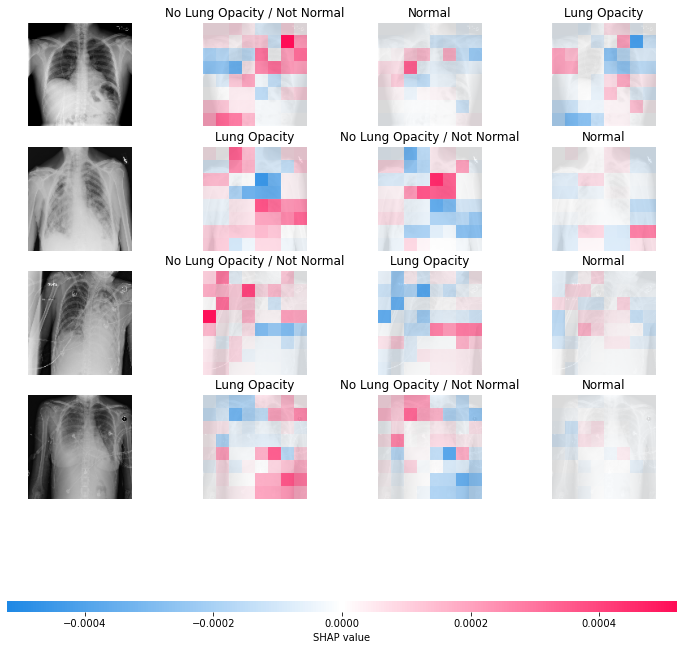

In [176]:
shap.image_plot(shap_values)

# Explainability for Basic CNN model

In [153]:
from tensorflow.keras.models import load_model
 
# load saved model
cnn = load_model('./models/cnn_basic.h5')

In [154]:
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
cnn.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [155]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

4534/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [156]:
import shap

In [157]:
shap.initjs()

In [158]:
classlabels = ["Lung Opacity", "No Lung Opacity / Not Normal", "Normal"]
masker = shap.maskers.Image("inpaint_telea", X_train.astype('float')[0].shape)

explainer = shap.Explainer(cnn, masker, output_names=classlabels)

explainer

In [159]:
shap_values = explainer(X_test.astype('float')[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

Partition explainer: 5it [00:15,  7.54s/it]                                                                                                                                                                  


(4, 128, 128, 3, 3)

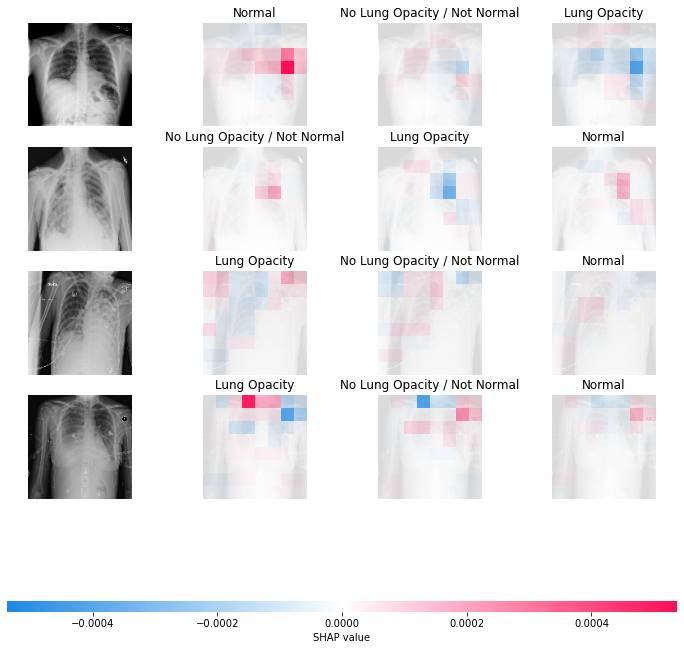

In [160]:
shap.image_plot(shap_values)

# Explainability for with ResNet-50 model

In [177]:
from tensorflow.keras.models import load_model
 
# load saved model
cnn_resnet = load_model('./models/cnn_resnet_final.h5')

In [178]:
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
cnn_resnet.compile(
    optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [179]:
fcl_loss3, fcl_accuracy3 = cnn_resnet.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss3)
print('Test accuracy:', fcl_accuracy3)

4534/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [180]:
import shap

In [181]:
shap.initjs()

In [182]:
classlabels = ["Lung Opacity", "No Lung Opacity / Not Normal", "Normal"]
masker = shap.maskers.Image("inpaint_telea", X_train.astype('float')[0].shape)

explainer = shap.Explainer(cnn_resnet, masker, output_names=classlabels)

explainer

In [183]:
shap_values = explainer(X_test.astype('float')[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [00:20,  6.87s/it]                                                                                                                                                                  


(4, 128, 128, 3, 3)

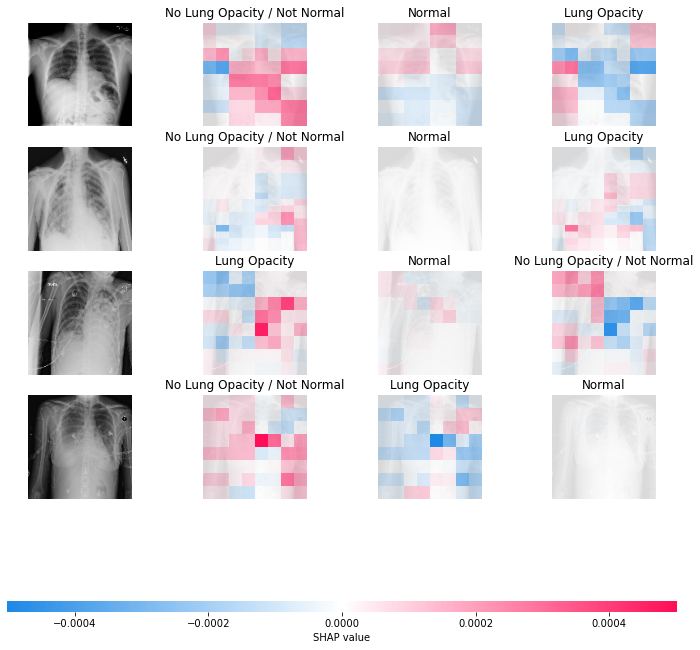

In [184]:
shap.image_plot(shap_values)